# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
#!pip install openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lhcsmapi.Time import Time
from lhcsmapi.analysis.RbCircuitQuery import RbCircuitQuery
from scipy import stats

from src.utils.mp3_excel_processing import get_fgc_timestamp, get_fgc_timestamp_missing
from src.utils.hdf_tools import load_from_hdf_with_regex

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

ImportError: cannot import name 'signal_metadata' from 'lhcsmapi.metadata' (/eos/user/c/cobermai/.local/lib/python3.8/site-packages/lhcsmapi/metadata/__init__.py)

In [1]:
import pandas as pd
pd.__version__

'1.2.2'

In [2]:


file_name = "../data/metadata_context_variables.xlsx"


df = pd.read_excel(file_name, engine="openpyxl")

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df_raw = pd.read_excel(f"../data/RB_TC_extract_{date_suffix}.xlsx")
len(mp3_fpa_df_raw)

4773

In [5]:
# First row contains units, 9 rows contain only "Before Notebooks" and "After Notebooks" information, which need to be droped
mp3_fpa_df = mp3_fpa_df_raw.dropna(subset = ['Date (FGC)', 'Circuit Name'])
mp3_fpa_df_raw.iloc[~mp3_fpa_df_raw.index.isin(mp3_fpa_df.index)] #show droped rows

,Circuit Name,Circuit Family,Period,Date (FGC),Time (FGC),FPA Reason,Timestamp_PIC,Delta_t(FGC-PIC),Delta_t(EE_even-PIC),Delta_t(EE_odd-PIC),...,Outer cable type,I_Q_SM18,dI_Q_Acc,dI_Q_LHC,Comment,Analysis performed by,lhcsmapi version,lhcsm notebook version,Unnamed: 46,Unnamed: 47
0,NaN,RB,NaN,2008-04-01 00:00:00,13:14:15,NaN,NaN,[ms],[ms],[ms],...,NaN,[A],[A],[A],NaN,NaN,NaN,NaN,NaN,NaN
1,RB.A12,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
169,RB.A23,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
264,RB.A34,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
545,RB.A45,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
897,RB.A56,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1146,RB.A67,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1268,RB.A78,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1430,RB.A81,RB,Before Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Before Notebooks,NaN,NaN,NaN
1581,NaN,RB,After Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,After Notebooks,NaN,NaN,NaN


# Find FGC timestamp for each FPA event in MP3 excel

In [6]:
mp3_fpa_df['timestamp_fgc'] = mp3_fpa_df.apply(get_fgc_timestamp, axis=1)

KeyboardInterrupt: 

# Find missing fgc timestamps in mp3 file

In [ ]:
# some fgc timestamps have wrong hours
mp3_fpa_df_primary_missing = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc.isna()) & (mp3_fpa_df['Nr in Q event'] == 1)]
mp3_fpa_df_primary_missing['timestamp_fgc'] = mp3_fpa_df_primary_missing.apply(get_fgc_timestamp_missing, axis=1)
found_fgc_timestamps_df = mp3_fpa_df_primary_missing["timestamp_fgc"].dropna()
mp3_fpa_df.loc[found_fgc_timestamps_df.index, "timestamp_fgc"] = mp3_fpa_df_primary_missing["timestamp_fgc"].dropna().values

In [ ]:
print(f"{len(mp3_fpa_df)} unique fgc events") # 841 Primary quenches?
print(f"{len(mp3_fpa_df[mp3_fpa_df['Nr in Q event']==1])} mp3 primary quench entries") # 834 primary quenches with correct notes

In [ ]:
mp3_fpa_df.to_csv(f"../data/RB_TC_extract_{date_suffix}_processed.csv")

# Select events to add features

In [8]:
mp3_fpa_df = pd.read_csv(f"../data/RB_TC_extract_{date_suffix}_processed.csv")
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])

# Time.to_string(1514761200000000000), Time.to_unix_timestamp('2018-01-01 00:00:00+01:00')
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

download_mask = pd.to_numeric(mp3_fpa_df_period_all['Delta_t(EE_odd-PIC)'], errors='coerce').isnull() | \
                pd.to_numeric(mp3_fpa_df_period_all['Delta_t(EE_even-PIC)'], errors='coerce').isnull()
mp3_fpa_df_to_download = mp3_fpa_df_period_all[download_mask]
print(len(mp3_fpa_df_to_download))

16


# Add features with NXCALS

In [9]:
k=0
for index, row in mp3_fpa_df_to_download.iterrows():
    try:
        loc_mask = (mp3_fpa_df.timestamp_fgc == row['timestamp_fgc']) & (mp3_fpa_df["Circuit Name"] == row['Circuit Name'])

        rb_query = RbCircuitQuery(row['Circuit Family'], row['Circuit Name'], max_executions=45)

        source_timestamp_ee_even_df = rb_query.find_source_timestamp_ee(int(row['timestamp_fgc']), system='EE_EVEN')
        timestamp_ee_even = source_timestamp_ee_even_df.timestamp[0]
        u_dump_res_even_df = rb_query.query_ee_u_dump_res_pm(timestamp_ee_even, int(row['timestamp_fgc']), system='EE_EVEN',
                                            signal_names=['U_DUMP_RES'])

        source_timestamp_ee_odd_df = rb_query.find_source_timestamp_ee(int(row['timestamp_fgc']), system='EE_ODD')
        timestamp_ee_odd = source_timestamp_ee_odd_df.timestamp[0]
        u_dump_res_odd_df = rb_query.query_ee_u_dump_res_pm(timestamp_ee_odd, int(row['timestamp_fgc']), system='EE_ODD',
                                            signal_names=['U_DUMP_RES'])

        timestamp_pic = rb_query.find_timestamp_pic(int(row['timestamp_fgc']), spark=spark)

        source_timestamp_qds_df = rb_query.find_source_timestamp_qds(int(row['timestamp_fgc']), duration=[(50, 's'), (500, 's')])
        timestamp_iQps = source_timestamp_qds_df.timestamp[0]

        # sometimes values are missing in the end
        ts_iQPS_PIC = 1e-6 * (source_timestamp_qds_df['timestamp'].values - min(timestamp_pic))
        mp3_fpa_df.loc[loc_mask, 'Delta_t(iQPS-PIC)'] = np.append(ts_iQPS_PIC, np.max(ts_iQPS_PIC)*np.ones(sum(loc_mask)-len(ts_iQPS_PIC)))

        mp3_fpa_df.loc[loc_mask, 'Delta_t(EE_odd-PIC)'] = (timestamp_ee_odd - min(timestamp_pic)) / 1e6
        mp3_fpa_df.loc[loc_mask, 'Delta_t(EE_even-PIC)'] = (timestamp_ee_even - min(timestamp_pic)) / 1e6
        mp3_fpa_df.loc[loc_mask, 'U_EE_max_ODD'] = u_dump_res_odd_df.max()[0]
        mp3_fpa_df.loc[loc_mask, 'U_EE_max_EVEN'] = u_dump_res_even_df.max()[0]
    except:
        k+=1
print(k)

	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 from 2015-03-12 07:45:24.640 to 2015-03-12 08:02:14.640


	Querying PM event signal(s) UA47.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 at 2015-03-12 07:45:35.211


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 from 2015-03-12 07:45:24.640 to 2015-03-12 08:02:14.640


	Querying PM event signal(s) RR53.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 at 2015-03-12 07:45:34.951


	Querying NXCALS signal(s) RB.A45.ODD:ST_ABORT_PIC, RB.A45.EVEN:ST_ABORT_PIC from 2015-03-12 07:45:33.640 to 2015-03-12 07:46:34.640


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2015-03-12 07:44:44.640 to 2015-03-12 07:53:54.640


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 from 2018-12-08 21:17:57.820 to 2018-12-08 21:34:47.820


	Querying PM event signal(s) UA47.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 at 2018-12-08 21:18:08.384


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 from 2018-12-08 21:17:57.820 to 2018-12-08 21:34:47.820


	Querying PM event signal(s) RR53.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 at 2018-12-08 21:18:07.889


	Querying NXCALS signal(s) RB.A45.ODD:ST_ABORT_PIC, RB.A45.EVEN:ST_ABORT_PIC from 2018-12-08 21:18:06.820 to 2018-12-08 21:19:07.820


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 21:17:17.820 to 2018-12-08 21:26:27.820


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 from 2018-12-08 21:17:57.820 to 2018-12-08 21:34:47.820


	Querying PM event signal(s) UA47.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 at 2018-12-08 21:18:08.384


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 from 2018-12-08 21:17:57.820 to 2018-12-08 21:34:47.820


	Querying PM event signal(s) RR53.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 at 2018-12-08 21:18:07.889


	Querying NXCALS signal(s) RB.A45.ODD:ST_ABORT_PIC, RB.A45.EVEN:ST_ABORT_PIC from 2018-12-08 21:18:06.820 to 2018-12-08 21:19:07.820


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 21:17:17.820 to 2018-12-08 21:26:27.820


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 from 2018-12-08 21:17:57.820 to 2018-12-08 21:34:47.820


	Querying PM event signal(s) UA47.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 at 2018-12-08 21:18:08.384


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 from 2018-12-08 21:17:57.820 to 2018-12-08 21:34:47.820


	Querying PM event signal(s) RR53.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 at 2018-12-08 21:18:07.889


	Querying NXCALS signal(s) RB.A45.ODD:ST_ABORT_PIC, RB.A45.EVEN:ST_ABORT_PIC from 2018-12-08 21:18:06.820 to 2018-12-08 21:19:07.820


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-08 21:17:17.820 to 2018-12-08 21:26:27.820


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 from 2018-12-09 12:32:17.780 to 2018-12-09 12:49:07.780


	Querying PM event signal(s) UA47.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 at 2018-12-09 12:32:28.343


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 from 2018-12-09 12:32:17.780 to 2018-12-09 12:49:07.780


	Querying PM event signal(s) RR53.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 at 2018-12-09 12:32:27.848


	Querying NXCALS signal(s) RB.A45.ODD:ST_ABORT_PIC, RB.A45.EVEN:ST_ABORT_PIC from 2018-12-09 12:32:26.780 to 2018-12-09 12:33:27.780


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 12:31:37.780 to 2018-12-09 12:40:47.780


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 from 2018-12-09 12:32:17.780 to 2018-12-09 12:49:07.780


	Querying PM event signal(s) UA47.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 at 2018-12-09 12:32:28.343


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 from 2018-12-09 12:32:17.780 to 2018-12-09 12:49:07.780


	Querying PM event signal(s) RR53.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 at 2018-12-09 12:32:27.848


	Querying NXCALS signal(s) RB.A45.ODD:ST_ABORT_PIC, RB.A45.EVEN:ST_ABORT_PIC from 2018-12-09 12:32:26.780 to 2018-12-09 12:33:27.780


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 12:31:37.780 to 2018-12-09 12:40:47.780


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 from 2018-12-09 12:32:17.780 to 2018-12-09 12:49:07.780


	Querying PM event signal(s) UA47.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA47.RB.A45 at 2018-12-09 12:32:28.343


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 from 2018-12-09 12:32:17.780 to 2018-12-09 12:49:07.780


	Querying PM event signal(s) RR53.RB.A45:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR53.RB.A45 at 2018-12-09 12:32:27.848


	Querying NXCALS signal(s) RB.A45.ODD:ST_ABORT_PIC, RB.A45.EVEN:ST_ABORT_PIC from 2018-12-09 12:32:26.780 to 2018-12-09 12:33:27.780


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2018-12-09 12:31:37.780 to 2018-12-09 12:40:47.780


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 from 2015-02-09 22:58:20.160 to 2015-02-09 23:15:10.160


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 from 2015-02-09 22:58:20.160 to 2015-02-09 23:15:10.160


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) UA63.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 at 2017-12-04 07:35:17.825


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) RR57.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 at 2017-12-04 07:35:17.583


	Querying NXCALS signal(s) RB.A56.ODD:ST_ABORT_PIC, RB.A56.EVEN:ST_ABORT_PIC from 2017-12-04 07:35:16.280 to 2017-12-04 07:36:17.280


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-12-04 07:34:27.280 to 2017-12-04 07:43:37.280


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) UA63.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 at 2017-12-04 07:35:17.825


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) RR57.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 at 2017-12-04 07:35:17.583


	Querying NXCALS signal(s) RB.A56.ODD:ST_ABORT_PIC, RB.A56.EVEN:ST_ABORT_PIC from 2017-12-04 07:35:16.280 to 2017-12-04 07:36:17.280


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-12-04 07:34:27.280 to 2017-12-04 07:43:37.280


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) UA63.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 at 2017-12-04 07:35:17.825


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) RR57.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 at 2017-12-04 07:35:17.583


	Querying NXCALS signal(s) RB.A56.ODD:ST_ABORT_PIC, RB.A56.EVEN:ST_ABORT_PIC from 2017-12-04 07:35:16.280 to 2017-12-04 07:36:17.280


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-12-04 07:34:27.280 to 2017-12-04 07:43:37.280


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) UA63.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 at 2017-12-04 07:35:17.825


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) RR57.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 at 2017-12-04 07:35:17.583


	Querying NXCALS signal(s) RB.A56.ODD:ST_ABORT_PIC, RB.A56.EVEN:ST_ABORT_PIC from 2017-12-04 07:35:16.280 to 2017-12-04 07:36:17.280


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-12-04 07:34:27.280 to 2017-12-04 07:43:37.280


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) UA63.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 at 2017-12-04 07:35:17.825


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) RR57.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 at 2017-12-04 07:35:17.583


	Querying NXCALS signal(s) RB.A56.ODD:ST_ABORT_PIC, RB.A56.EVEN:ST_ABORT_PIC from 2017-12-04 07:35:16.280 to 2017-12-04 07:36:17.280


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-12-04 07:34:27.280 to 2017-12-04 07:43:37.280


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) UA63.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 at 2017-12-04 07:35:17.825


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) RR57.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 at 2017-12-04 07:35:17.583


	Querying NXCALS signal(s) RB.A56.ODD:ST_ABORT_PIC, RB.A56.EVEN:ST_ABORT_PIC from 2017-12-04 07:35:16.280 to 2017-12-04 07:36:17.280


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-12-04 07:34:27.280 to 2017-12-04 07:43:37.280


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) UA63.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: UA63.RB.A56 at 2017-12-04 07:35:17.825


	Querying PM event timestamps for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 from 2017-12-04 07:35:07.280 to 2017-12-04 07:51:57.280


	Querying PM event signal(s) RR57.RB.A56:U_DUMP_RES for system: QPS, className: DQAMSNRB, source: RR57.RB.A56 at 2017-12-04 07:35:17.583


	Querying NXCALS signal(s) RB.A56.ODD:ST_ABORT_PIC, RB.A56.EVEN:ST_ABORT_PIC from 2017-12-04 07:35:16.280 to 2017-12-04 07:36:17.280


	Querying PM event timestamps for system: QPS, className: DQAMCNMB_PMSTD, source: * from 2017-12-04 07:34:27.280 to 2017-12-04 07:43:37.280
16


# Add features by calculation

In [11]:
mp3_fpa_df = pd.read_csv(f"../data/RB_TC_extract_{date_suffix}_processed_filled.csv")
print(len(mp3_fpa_df))

4006


In [12]:
#fpa_identifier
mp3_fpa_df.loc[mp3_fpa_df['timestamp_fgc'].dropna().index, "fpa_identifier"] = [f"{row['Circuit Family']}_{row['Circuit Name']}_{int(row['timestamp_fgc'])}" for i, row in mp3_fpa_df.loc[mp3_fpa_df['timestamp_fgc'].dropna().index].iterrows()]

#drop duplicated entries:
mp3_fpa_df = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier', 'Position'])

#find subsets
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
# Time.to_string(1514761200000000000), Time.to_unix_timestamp('2018-01-01 00:00:00+01:00')
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

# find data which does not contain quench timestamps
failed_mask = pd.to_numeric(mp3_fpa_df_period_all['Delta_t(EE_odd-PIC)'], errors='coerce').isnull() | \
                pd.to_numeric(mp3_fpa_df_period_all['Delta_t(EE_even-PIC)'], errors='coerce').isnull()
mp3_fpa_df_to_analyze = mp3_fpa_df_period_all[~failed_mask]
print(sum(failed_mask))

NameError: name 'Time' is not defined

In [49]:
# add features for simulation
mp3_fpa_df_new = mp3_fpa_df_to_analyze.copy()
for i, row in mp3_fpa_df_to_analyze.iterrows():
    mask = mp3_fpa_df_new.fpa_identifier == row["fpa_identifier"]
    mp3_fpa_df_subset = mp3_fpa_df_period_all[mask]
    mp3_fpa_df_new.loc[mask, "R_EE_odd"] = float(mp3_fpa_df_subset['U_EE_max_ODD'].values[0]) / float(mp3_fpa_df_subset['I_Q_M'].max())
    mp3_fpa_df_new.loc[mask, "R_EE_even"] = float(mp3_fpa_df_subset['U_EE_max_EVEN'].values[0]) / float(mp3_fpa_df_subset['I_Q_M'].max())
    mp3_fpa_df_new.loc[mask, "t_EE_odd"] = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
    mp3_fpa_df_new.loc[mask, "t_EE_even"] = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000
    mp3_fpa_df_new.loc[mask, "I_end_2_from_data"] = mp3_fpa_df_subset['I_Q_M'].max()

In [28]:
#mp3_fpa_df_new.to_csv(f"../data/RB_TC_extract_{date_suffix}_processed_filled.csv",index=False)

# Add features from downloaded data

In [5]:
mp3_fpa_df = pd.read_csv(f"../data/RB_TC_extract_{date_suffix}_processed_filled.csv")
print(len(mp3_fpa_df))

3981


In [98]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / '20220707_data'

In [108]:
for i, fpa_identifier in enumerate(mp3_fpa_df["fpa_identifier"].unique()):

    mask = mp3_fpa_df["fpa_identifier"] == fpa_identifier
    data_dir = data_path / (fpa_identifier + ".hdf5")
    I_MEAS = load_from_hdf_with_regex(file_path=data_dir, regex_list=["I_MEAS"])[0]
    
    k, intercept, r, p, std_err = stats.linregress(I_MEAS.loc[-1:0].index.values, I_MEAS.loc[-1:0].values.reshape(-1))
    mp3_fpa_df.loc[mask, "dI_dt_from_data"] = k #current change per second before quench
    print(f"{i}/{len(mp3_fpa_df['fpa_identifier'].unique())}")

0/828
1/828
2/828
3/828
4/828
5/828
6/828
7/828
8/828
9/828
10/828
11/828
12/828
13/828
14/828
15/828
16/828
17/828
18/828
19/828
20/828
21/828
22/828
23/828
24/828
25/828
26/828
27/828
28/828
29/828
30/828
31/828
32/828
33/828
34/828
35/828
36/828
37/828
38/828
39/828
40/828
41/828
42/828
43/828
44/828
45/828
46/828
47/828
48/828
49/828
50/828
51/828
52/828
53/828
54/828
55/828
56/828
57/828
58/828
59/828
60/828
61/828
62/828
63/828
64/828
65/828
66/828
67/828
68/828
69/828
70/828
71/828
72/828
73/828
74/828
75/828
76/828
77/828
78/828
79/828
80/828
81/828
82/828
83/828
84/828
85/828
86/828
87/828
88/828
89/828
90/828
91/828
92/828
93/828
94/828
95/828
96/828
97/828
98/828
99/828
100/828
101/828
102/828
103/828
104/828
105/828
106/828
107/828
108/828
109/828
110/828
111/828
112/828
113/828
114/828
115/828
116/828
117/828
118/828
119/828
120/828
121/828
122/828
123/828
124/828
125/828
126/828
127/828
128/828
129/828
130/828
131/828
132/828
133/828
134/828
135/828
136/828
137/828
138/82

8.361036199095


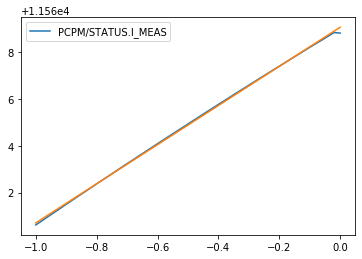

In [95]:
fpa_identifier = "RB_RB.A78_1636654131900000000"
mask = mp3_fpa_df["fpa_identifier"] == fpa_identifier
data_dir = data_path / (fpa_identifier + ".hdf5")
I_MEAS = load_from_hdf_with_regex(file_path=data_dir, regex_list=["I_MEAS"])[0]

k, intercept, r, p, std_err = stats.linregress(I_MEAS.loc[-1:0].index.values, I_MEAS.loc[-1:0].values.reshape(-1))

x = I_MEAS.loc[-1:0].index.values
I_MEAS.loc[-1:0].plot()
plt.plot(x, x*k + intercept)
print(k )

In [6]:
mp3_fpa_df[['dU_iQPS/dt','R_DL_max',"dI_Q_Acc"]] = mp3_fpa_df[['dU_iQPS/dt','R_DL_max',"dI_Q_Acc"]].apply(pd.to_numeric, errors='coerce')

In [7]:
mp3_fpa_df.to_csv(f"../data/RB_TC_extract_{date_suffix}_processed_filled.csv")

# Add magnet metadata

In [53]:
mp3_fpa_df = pd.read_csv(f"../data/RB_TC_extract_{date_suffix}_processed_filled.csv")
mp3_fpa_df['Magnet'] = mp3_fpa_df.Position.apply(lambda x: "MB." + x )
print(len(mp3_fpa_df))

3981


In [3]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path)

In [4]:
for circuit in rb_magnet_metadata.Circuit.unique():
    rb_magnet_metadata.loc[rb_magnet_metadata.Circuit==circuit,'phys_position'] = np.arange(1, 155)

<AxesSubplot:>

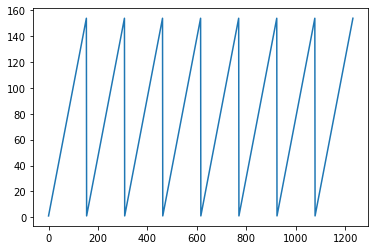

In [5]:
rb_magnet_metadata['phys_position'].plot()

In [56]:
mp3_fpa_df_new = mp3_fpa_df.merge(rb_magnet_metadata, left_on=['Circuit Name', 'Magnet'], right_on=['Circuit', 'Magnet'], how="left", suffixes=('', '_1'))

In [57]:
mp3_fpa_df_new.to_csv(f"../data/RB_TC_extract_{date_suffix}_processed_filled.csv", index=False)